# Data exploration

In [1]:
!ls ../data/ukwac-dep

ukwac_dep_parsed_01.gz ukwac_dep_parsed_03.gz ukwac_dep_parsed_05.gz
ukwac_dep_parsed_02.gz ukwac_dep_parsed_04.gz


In [2]:
!gzcat ../data/ukwac-dep/ukwac_dep_parsed_01.gz | head -n 20

<text id="ukwac:http://observer.guardian.co.uk/osm/story/0,,1009777,00.html">
<s>
Hooligans	hooligan	NNS	1	4	NMOD
,	,	,	2	4	P
unbridled	unbridled	JJ	3	4	NMOD
passion	passion	NN	4	0	ROOT
-	-	:	5	4	P
and	and	CC	6	4	CC
no	no	DT	7	9	NMOD
executive	executive	JJ	8	9	NMOD
boxes	box	NNS	9	4	COORD
.	.	SENT	10	0	ROOT
</s>
<s>
Portsmouth	Portsmouth	NP	1	2	SBJ
are	are	VBP	2	0	ROOT
a	a	DT	3	4	NMOD
reminder	reminder	NN	4	2	PRD
of	of	IN	5	4	NMOD
how	how	WRB	6	8	ADV
gzcat: error writing to output: Broken pipe
gzcat: ../data/ukwac-dep/ukwac_dep_parsed_01.gz: uncompress failed


In [3]:
import sys
if '..' not in sys.path: 
    sys.path.append('..')

In [4]:
%matplotlib inline
from conll import parse_dep_tree
import gzip
from tqdm import tqdm
from glob import glob
from ukwac import *
from itertools import islice
from collections import Counter
import seaborn as sns
import pandas as pd
import re
from joblib import Parallel, delayed
import os

In [5]:
paths = sorted(glob('../data/ukwac-dep/*.gz'))

In [6]:
with gzip.open(paths[0], 'r') as f:
    lines = f.readlines(10000)
parse_dep_tree(list(iter_sentences(lines))[0], 'ukwac')

[{'token': 'Hooligans',
  'lemma': 'hooligan',
  'pos': 'NNS',
  'head': 3,
  'label': 'NMOD',
  'tokens': {0}},
 {'token': ',',
  'lemma': ',',
  'pos': ',',
  'head': 3,
  'label': 'P',
  'tokens': {1}},
 {'token': 'unbridled',
  'lemma': 'unbridled',
  'pos': 'JJ',
  'head': 3,
  'label': 'NMOD',
  'tokens': {2}},
 {'token': 'passion',
  'lemma': 'passion',
  'pos': 'NN',
  'head': -1,
  'label': 'ROOT',
  'tokens': {0, 1, 2, 3, 4, 5, 6, 7, 8}},
 {'token': '-',
  'lemma': '-',
  'pos': ':',
  'head': 3,
  'label': 'P',
  'tokens': {4}},
 {'token': 'and',
  'lemma': 'and',
  'pos': 'CC',
  'head': 3,
  'label': 'CC',
  'tokens': {5}},
 {'token': 'no',
  'lemma': 'no',
  'pos': 'DT',
  'head': 8,
  'label': 'NMOD',
  'tokens': {6}},
 {'token': 'executive',
  'lemma': 'executive',
  'pos': 'JJ',
  'head': 8,
  'label': 'NMOD',
  'tokens': {7}},
 {'token': 'boxes',
  'lemma': 'box',
  'pos': 'NNS',
  'head': 3,
  'label': 'COORD',
  'tokens': {6, 7, 8}},
 {'token': '.',
  'lemma': '.',


In [7]:
%%time
dep_trees = list(islice(iter_dep_trees(paths), 10000))

25604lines [00:00, 127919.02lines/s]

Reading "../data/ukwac-dep/ukwac_dep_parsed_01.gz"


267707lines [00:03, 88155.17lines/s]

Error occurred at sentence 10000. Skipped.
['It\tit\tPP\t1\t2\tSBJ', 'will\twill\tMD\t2\t0\tROOT', 'also\talso\tRB\t3\t2\tADV', 'start\tstart\tVV\t4\t2\tVC', 'to\tto\tTO\t5\t6\tVMOD', 'deliver\tdeliver\tVV\t6\t4\tOBJ', 'powerful\tpowerful\tJJ\t7\t6\tPRD', ',\t,\t,\t8\t7\tP', 'targeted\ttargeted\tJJ\t9\t7\tCOORD', ',\t,\t,\t10\t7\tP', 'effective\teffective\tJJ\t11\t7\tCOORD', 'and\tand\tCC\t12\t7\tCC', 'flexible\tflexible\tJJ\t13\t7\tCOORD', 'communication\tcommunication\tNN\t14\t15\tNMOD', 'plans\tplan\tNNS\t15\t6\tOBJ', '.\t.\tSENT\t16\t2\tP']
CPU times: user 2.78 s, sys: 206 ms, total: 2.99 s
Wall time: 3.12 s


Exception ignored in: <generator object iter_dep_trees_from_file at 0x10ed69f10>
RuntimeError: generator ignored GeneratorExit



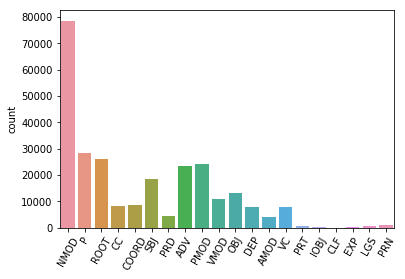

In [8]:
ax = sns.countplot([dep['label'] for deps in dep_trees for dep in deps])
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=60)

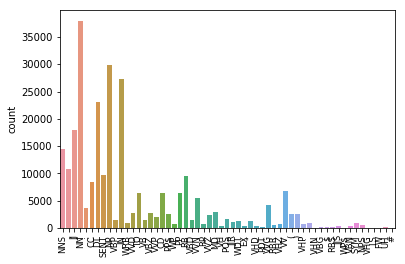

In [9]:
ax = sns.countplot([dep['pos'] for deps in dep_trees for dep in deps])
_ = ax.set_xticklabels(ax.get_xticklabels(), fontsize='small', rotation=90)

# Couting verbs and nouns

In [10]:
%%time

def write_verbs_and_noun_single_process(inp_path, verb_out_path, noun_out_path, idx):
    with gzip.open(verb_out_path, 'wb') as fv_out, \
            gzip.open(noun_out_path, 'wb') as fn_out:
        for dep_tree in iter_dep_trees_from_file(
                    iter_lines_counting(inp_path, idx)):
            for dep in dep_tree:
                if is_valid_verb(dep):
                    fv_out.write(normalize(dep).encode('utf-8'))
                    fv_out.write(b'\n')
                elif is_valid_noun(dep):
                    fn_out.write(normalize(dep).encode('utf-8'))
                    fn_out.write(b'\n')

print('Progress is printed to command line instead of notebook.')
out_dir = '../output/ukwac-counts.tmp'
os.makedirs(out_dir, exist_ok=True)
out_verb_path_pattern = os.path.join(out_dir, 'verbs-%02d.txt.gz')
out_noun_path_pattern = os.path.join(out_dir, 'nouns-%02d.txt.gz')
Parallel(n_jobs=3)(delayed(write_verbs_and_noun_single_process)(p, out_verb_path_pattern%i, 
                                                                out_noun_path_pattern%i, i)
                   for i, p in enumerate(paths))

Progress is printed to command line instead of notebook.


KeyboardInterrupt: 

In [21]:
%%time
%%sh
mkdir ../output/ukwac-counts
gzcat ../output/ukwac-counts.tmp/nouns*.txt.gz | sort | uniq -c | sort -n -r | gzip > ../output/ukwac-counts/nouns.txt.gz
gzcat ../output/ukwac-counts.tmp/verbs*.txt.gz | sort | uniq -c | sort -n -r | gzip > ../output/ukwac-counts/verbs.txt.gz


mkdir: ../output/ukwac-counts: File exists
gzcat: ../output/ukwac-counts.tmp/nouns-03.txt.gz: unexpected end of file
gzcat: ../output/ukwac-counts.tmp/nouns-04.txt.gz: unexpected end of file
gzcat: invalid compressed data--crc error
gzcat: ../output/ukwac-counts.tmp/verbs-02.txt.gz: uncompress failed
gzcat: ../output/ukwac-counts.tmp/verbs-03.txt.gz: unexpected end of file
gzcat: ../output/ukwac-counts.tmp/verbs-04.txt.gz: unexpected end of file


CPU times: user 11.7 ms, sys: 14.9 ms, total: 26.7 ms
Wall time: 5min 30s


In [27]:
%%sh
gzcat ../output/ukwac-counts/nouns.txt.gz | grep " 1 " | tail

   1 aaaaanzlaaarrr
   1 aaaaahhhh
   1 aaaaah
   1 aaaaages
   1 aaaaaarrrghhhh
   1 aaaaaahhhhh
   1 aaaaaahhhh
   1 aaaaaaghhhhhhh
   1 aaaaaaan
   1 aaaaaaaaaaaaaaaaaaagh


In [28]:
%%sh
gzcat ../output/ukwac-counts/nouns.txt.gz | grep " 2 " | tail

   2 abanim
   2 ab
   2 aaw
   2 aater
   2 aarti
   2 aarons
   2 aarkle
   2 aalge
   2 aaaah
   2 aaaa


In [29]:
%%sh
gzcat ../output/ukwac-counts/nouns.txt.gz | grep " 3 " | tail

   3 abdallah
   3 abcmidi
   3 abcess
   3 abcdefghijklmnopqrstuvwxyz
   3 abbreviatio
   3 abbie
   3 abantensis
   3 aahaayson
   3 aafa
   3 aabody


In [30]:
%%sh
gzcat ../output/ukwac-counts/nouns.txt.gz | grep " 10 " | tail

  10 advise
  10 adjacency
  10 adenoma
  10 activboards
  10 acth
  10 acess
  10 acapella
  10 absurdist
  10 aat
  10 aadir


In [31]:
%%sh
gzcat ../output/ukwac-counts/nouns.txt.gz | grep " 20 " | tail

  20 alkaloid
  20 airshow
  20 airlift
  20 aerofoil
  20 adm
  20 addon
  20 adapting
  20 acquiescence
  20 acolyte
  20 acetylcholine
